In [12]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer

import numpy as np
from timeit import default_timer as timer

class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        self.mc_price = -1

    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def BSM_Greeks(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        time_bs_start = timer()
        bs_price = european_option.NPV()
        delta = european_option.delta()
        gamma = european_option.gamma() #second order
        vega = european_option.vega()
        rho = european_option.rho()
        theta = european_option.theta()
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
#         print("Delta is ", delta)#Change in underlying price
#         print("Gamma is ", gamma)#second order: rate of change in price
#         print("Tho is ", rho)#Change in interest rate
#         print("Vega is ", vega)#Change in volatility
#         print("Theta is ", theta)#Change in time to expiration
#         print("Time used for BS calculation in total is ", time_bs, ' seconds')
        greeks_output = [('bs', delta, gamma, rho, vega, theta, time_bs)]
        dataframe = pd.DataFrame(greeks_output)
        dataframe.columns = ['method','delta', 'gamma', 'rho', 'vega', 'theta', 'time']
        return dataframe

    '''
    MC by hand.
    https://qsctech-sange.github.io/Options-Calculator.html#%E5%AE%8C%E6%95%B4%E4%BB%A3%E7%A0%81
    
    '''
    def MC_price(self):
        iteration = 100000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        zt = np.random.normal(0, 1, iteration)

        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * zt)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    '''
    https://chixiaoxue.github.io/2018/08/15/Python%E5%AE%9E%E7%8E%B0%E8%92%99%E7%89%B9%E5%8D%A1%E6%B4%9B%E6%A8%A1%E6%8B%9F%E7%9A%84%E6%9C%9F%E6%9D%83%E4%BC%B0%E5%80%BC/
    '''
    def MC_A_price(self):
        iteration = 1000000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        #zt = np.random.normal(0, 1, iteration)
        np.random.seed(1000)
        ran = np.random.standard_normal((1,1, round(iteration/2)))
        ran = np.concatenate((ran,-ran),axis=2)
        ran = ran-np.mean(ran)
        ran = ran/np.std(ran)
        
        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * ran)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    def MC_A_Greeks(self):
        if self.mc_price == -1:
            self.MC_A_price()
            
        p_original = self.mc_price
        time_bs_start = timer()
        
        original_stock = self.stock_price
        change_stock_price = 0.1
        self.stock_price = original_stock + change_stock_price
        p_plus = self.MC_A_price()
        self.stock_price = original_stock - change_stock_price
        p_minus = self.MC_A_price()
        self.stock_price = original_stock
        mc_delta = (p_plus - p_minus) / (2*change_stock_price)
        mc_gamma = (p_plus - 2*p_original + p_minus) /(change_stock_price*change_stock_price)

        change_r = 0.001
        original_r = self.risk_free_rate
        self.risk_free_rate = original_r + change_r
        p_plus = self.MC_A_price()
        self.risk_free_rate = original_r
        mc_rho = (p_plus - p_original) / change_r
        
        change_sigma = 0.001
        original_sigma = self.volatility
        self.volatility = original_sigma + change_sigma
        p_plus = self.MC_A_price()
        self.volatility = original_sigma
        mc_vega = (p_plus - p_original) / change_sigma
        
        self.calculation_date += 1
        p_plus = self.MC_A_price()
        change_in_time = 1.0 / 365
        mc_theta = (p_plus - p_original) / change_in_time
        
        self.mc_price = p_original
        
        time_bs_end = timer()
        time_mc = time_bs_end - time_bs_start

        greeks_output = [('mc', mc_delta, mc_gamma, mc_rho, mc_vega, mc_theta, time_mc)]
        dataframe = pd.DataFrame(greeks_output)
        dataframe.columns = ['method','delta', 'gamma', 'rho', 'vega', 'theta', 'time']
        return dataframe
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


In [13]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option)
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe

def random_options_uniform(numbers = 0, index = 100):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    numbers = 10 
    maturity = np.linspace(xldate1, xldate2+1, 10)
    stock_price = np.linspace(100, 500, 10)
    strike_price = np.linspace(7, 650, 10)
    volatility = np.linspace(0.05, 0.90, 10)
    dividend_rate = np.linspace(0, 0.003, 10)
    risk_free_rate = np.linspace(0.001, 0.003, 10)
    option_type = ql.Option.Call
    
    counter = 0
    for i in range(numbers):
        for j in range(numbers):
            for k in range(numbers):
                for l in range(numbers):
                    for m in range(numbers):
                        for n in range(numbers):
                            counter += 1
                            if counter == index:
                                option = Option(calculation_date, ql.Date(int(maturity[i])), stock_price[j], strike_price[k], volatility[l], dividend_rate[m], risk_free_rate[n], option_type)
                                options.append(option)
    
    return options

def random_options_pd_uniform(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    numbers = 10 
    maturity = np.linspace(xldate1, xldate2+1, 10)
    stock_price = np.linspace(100, 500, 10)
    strike_price = np.linspace(7, 650, 10)
    volatility = np.linspace(0.05, 0.90, 10)
    dividend_rate = np.linspace(0, 0.003, 10)
    risk_free_rate = np.linspace(0.001, 0.003, 10)
    option_type = ql.Option.Call
    
    for i in range(numbers):
        for j in range(numbers):
            for k in range(numbers):
                for l in range(numbers):
                    for m in range(numbers):
                        for n in range(numbers):
                            option = Option(calculation_date, ql.Date(int(maturity[i])), stock_price[j], strike_price[k], volatility[l], dividend_rate[m], risk_free_rate[n], option_type)
                            options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


In [14]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

def CheckAccuracy_RealPrice(x,y,y_hat):
    stats = dict()
    
    strike = x['strike_price'].values
    y = y * strike
    y_hat = y_hat * strike
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])


    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats
    
def CheckAccuracy_scaled(scale,y,y_hat):
    stats = dict()
    
    y = (y - scale.min_[6])/scale.scale_[6] 
    y_hat = (y_hat - scale.min_[6])/scaler.scale_[6] 
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])
    
    stats['diff_percentage'] = 100 * stats['diff'] / y
    np.where(stats['diff_percentage'] > 1)
    print(stats['diff_percentage'])

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    

In [15]:
def DL_prediction(model, df):
    df['stock_price'] = df['stock_price']/df['strike_price']
    df['call_price'] = df['call_price']/df['strike_price']
    greek_input = df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = model.predict(greek_input)[0][0] 
    return nn_original_price

def DL_prediction_scaled(scaler, model, df):
    scaled_training = scaler.transform(df)
    input_df = pd.DataFrame(scaled_training,columns=df.columns.values)
    greek_input = input_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = (model.predict(greek_input)[0][0]  - scaler.min_[6])/scaler.scale_[6] 
    return nn_original_price

def DL_Greeks(scaler, model, df):
    
    time_dl_start = timer()
    
#The Greeks for DL model
#why it's forever negative, problem is my saving variables for Python!!

    change_stock_price = 0.1
    original_price = DL_prediction_scaled(scaler, model, df)
    
    df['stock_price'] = df['stock_price'] + change_stock_price
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']]
    p_plus = DL_prediction_scaled(scaler, model, greek_input)

    df['stock_price'] = df['stock_price'] - 2*change_stock_price
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']]
    p_minus = DL_prediction_scaled(scaler, model, greek_input)
    df['stock_price'] = df['stock_price'] + change_stock_price

    dl_delta = (p_plus - p_minus) / (2*change_stock_price)
    dl_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)

    change_r = 0.001
    df['risk_free_rate'] = df['risk_free_rate'] + change_r
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']]
    p_plus = DL_prediction_scaled(scaler, model, greek_input)
    df['risk_free_rate'] = df['risk_free_rate'] - change_r
    dl_rho = (p_plus - original_price) / change_r

    change_sigma = 0.001
    df['volatility'] = df['volatility'] + change_sigma
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']]
    p_plus = DL_prediction_scaled(scaler, model, greek_input)
    df['volatility'] = df['volatility'] - change_sigma
    dl_vega = (p_plus - original_price) / change_sigma

    change_in_time = 1.0 / 365
    df['maturity'] = df['maturity'] - change_in_time
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']]
    p_later = DL_prediction_scaled(scaler, model, greek_input)
    dl_theta = (p_later - original_price) / change_in_time

    time_dl_end = timer()
    time_dl = time_dl_end - time_dl_start

    greeks_output = [('dl', dl_delta, dl_gamma, dl_rho, dl_vega, dl_theta, time_dl)]
    dataframe = pd.DataFrame(greeks_output)
    dataframe.columns = ['method','delta', 'gamma', 'rho', 'vega', 'theta', 'time']
    return dataframe

In [16]:
# n = 1000000
# random_df = pd.read_pickle('random_data_1m.pkl')
# uniform_df = pd.read_pickle('uniform_data_1m.pkl')
# df = uniform_df
# df = df.sample(frac=1).reset_index(drop=True)

In [17]:
from sklearn.preprocessing import MinMaxScaler


train = pd.read_pickle('uniform_data_train.pkl')
test = pd.read_pickle('uniform_data_test.pkl')

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = scaled_training_df['call_price'].values
X_test = scaled_testing_df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = scaled_testing_df['call_price'].values

mutiplying by 0.0020278705 and adding 0.000000


In [18]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_uniform.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights_uniform.h5")
print("Loaded model from disk")
loaded_model.summary()

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model = loaded_model

Loaded model from disk
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


[1.11575955e-09 5.37914796e-09 5.99398370e-09 ... 6.28713416e-03
 6.30916575e-03 6.33122341e-03]
Mean Squared Error:       1.3990707341188953e-06
Root Mean Squared Error:  0.0011828232049291623
Mean Absolute Error:      0.000807185090056496
Mean Percent Error:       0.00526521754932386


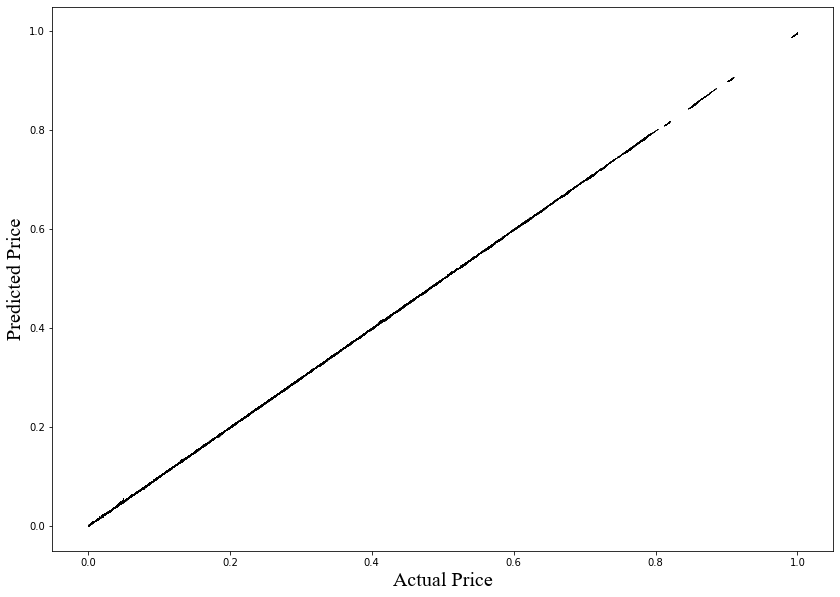

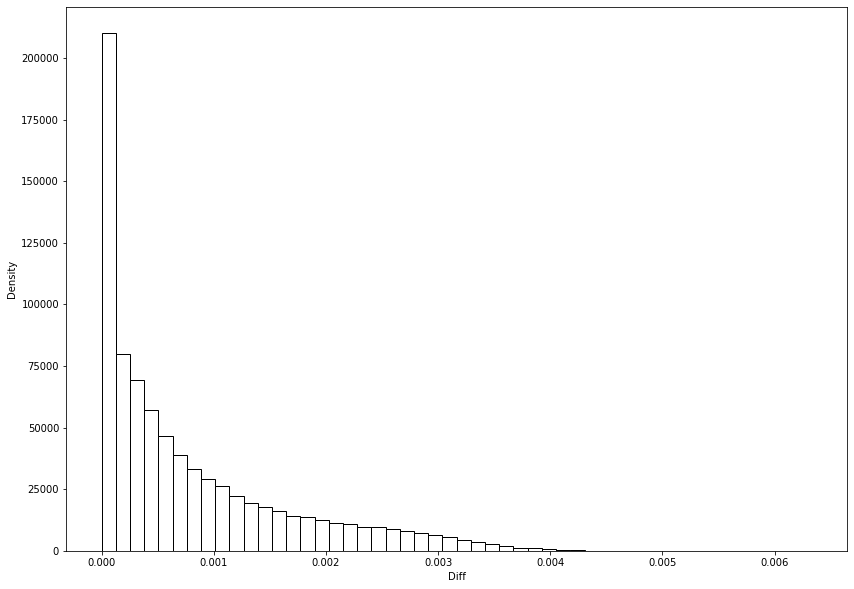

----------------------------------------------------------------------------------------------------
[8.26666985e-10 2.94953603e-09 7.44776156e-09 ... 6.15484765e-03
 6.17689417e-03 6.24305607e-03]
Mean Squared Error:       1.3945340903107812e-06
Root Mean Squared Error:  0.0011809039293315868
Mean Absolute Error:      0.0008053878888260808
Mean Percent Error:       0.005274099968306653


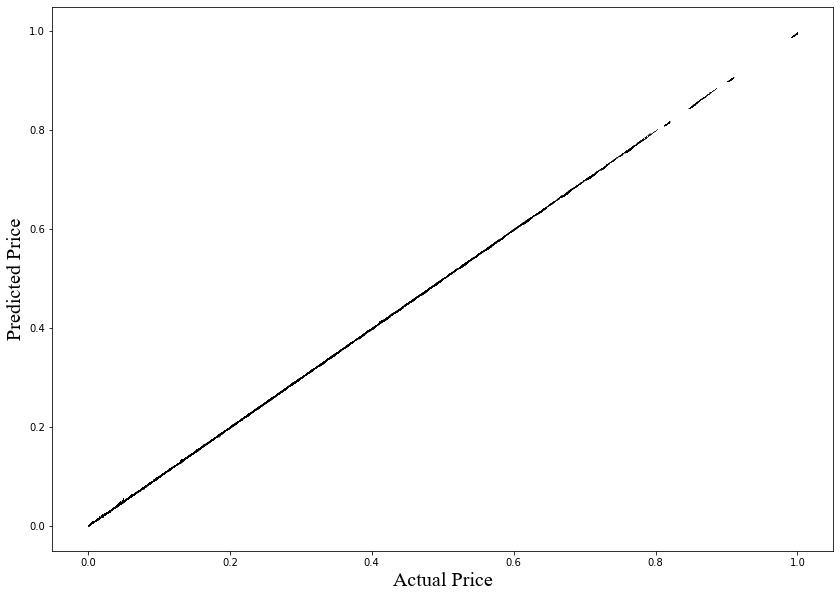

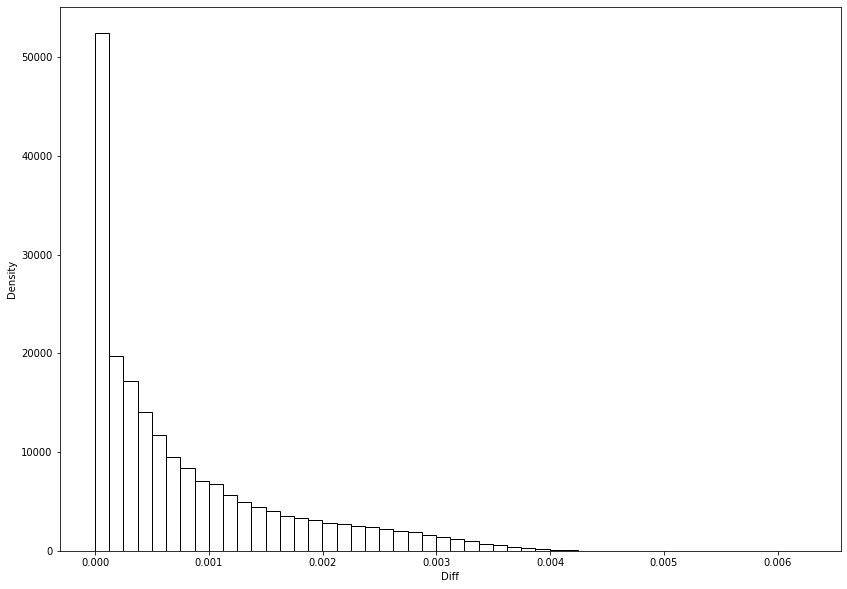

----------------------------------------------------------------------------------------------------
[2.21720002e-06 3.66901899e-06 3.93237831e-06 ... 3.03512792e+00
 3.04599831e+00 3.07862472e+00]
[5.48640893e-07 9.77694277e-07 1.97731141e-06 ... 1.67546918e+00
 2.16757875e+04 1.25765429e+00]


e:\ucl\year 3\individual project\ml\nnforoptionspricing\venv\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error:       0.3391229622053017
Root Mean Squared Error:  0.5823426501685255
Mean Absolute Error:      0.3971629882267439
Mean Percent Error:       0.005274151662706379


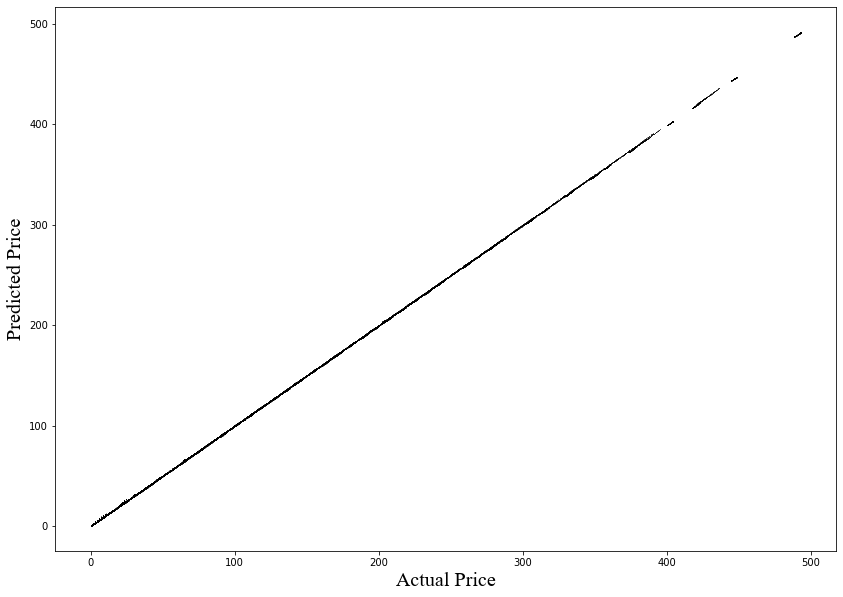

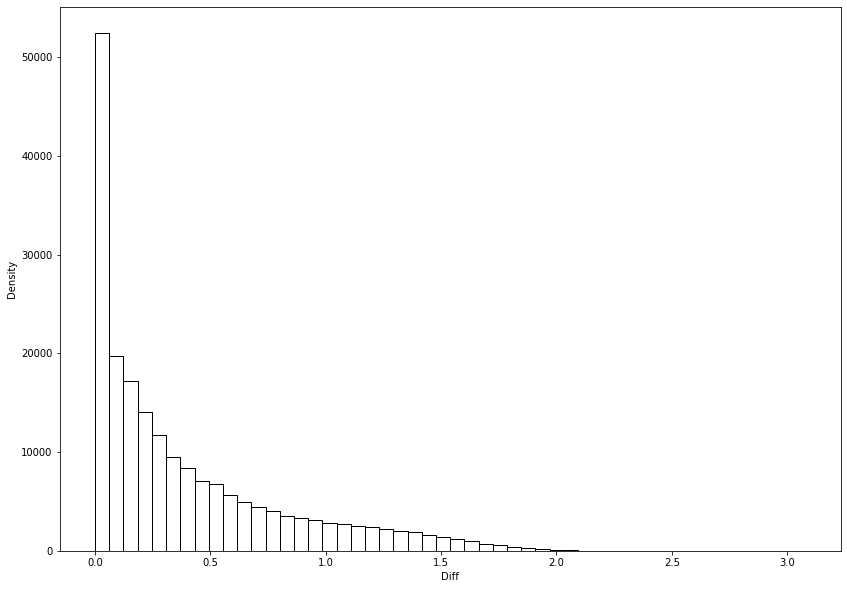

In [8]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
y_train_hat = model.predict(X_train)
y_train_hat = np.squeeze(y_train_hat)

CheckAccuracy(y_train, y_train_hat)
print('-'*100)
CheckAccuracy(y_test, y_test_hat)
print('-'*100)
CheckAccuracy_scaled(scaler, y_test, y_test_hat)


In [19]:
def sample_option(numbers = 1000, start = 155, end = 160):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    maturity = ql.Date(random.randint(xldate1, xldate2+1))
    strike_price = 150
    volatility = random.uniform(0.05, 0.90)
    dividend_rate = random.uniform(0, 0.003)
    risk_free_rate = random.uniform(0.001, 0.003)
    option_type = ql.Option.Call
    stock_price = np.linspace(start, end, numbers)
    for number in range(numbers):
        option = Option(calculation_date, maturity, stock_price[number], strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option)
    return options

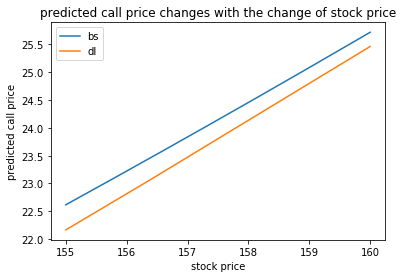

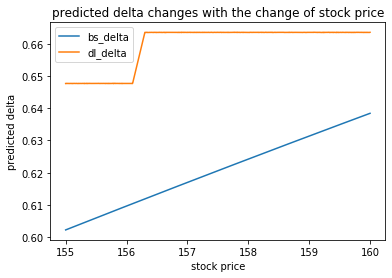

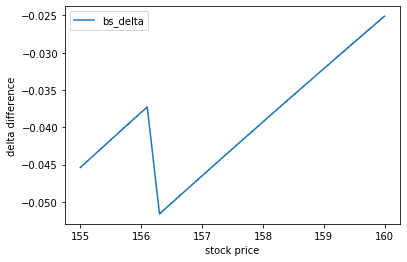

------------------------------------------------------------------------------------------------------------------------------------------------------


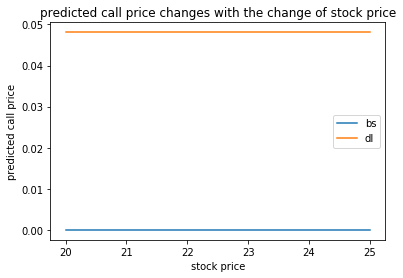

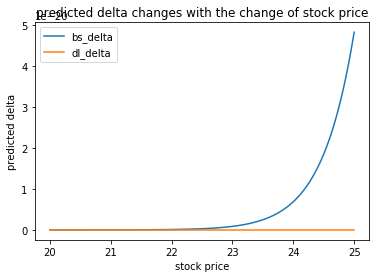

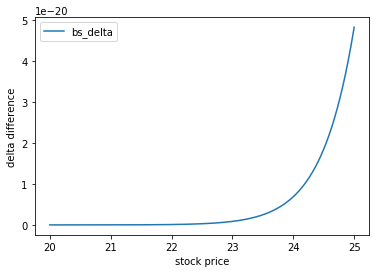

------------------------------------------------------------------------------------------------------------------------------------------------------


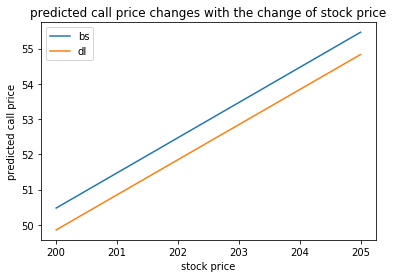

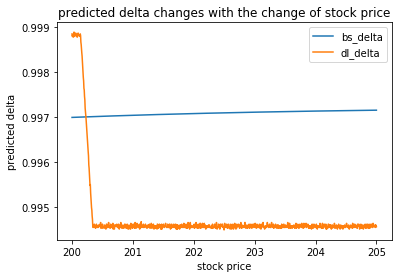

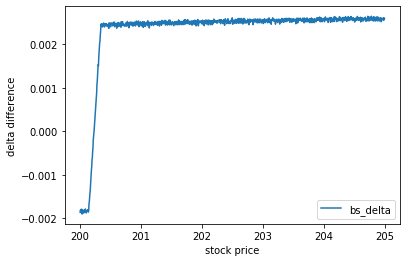

------------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
def delta_check(start, end):
    number = 1000
    options = sample_option(number,start, end)
    dl_prices = []
    bs_prices = []
    stock_prices = []
    bs_delta = []
    dl_delta = []
    for option in options:
        dataframe = pd.DataFrame([option.data_set()])
        dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
        stock_prices += (dataframe['stock_price'].values.tolist())
        dl_prices.append(DL_prediction_scaled(scaler, model, dataframe))
        bs_prices.append(option.BSM_price())
        bs_delta.append((option.BSM_Greeks())['delta'])
        dl_delta.append((DL_Greeks(scaler, model, dataframe))['delta'])

    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter 

    stats = dict()

    stats['theta_diff'] = [i - j for i, j in zip(bs_delta, dl_delta)]
    plt.plot(stock_prices, bs_prices, label = 'bs') 
    plt.plot(stock_prices, dl_prices, label = 'dl')
    plt.xlabel('stock price')
    plt.ylabel('predicted call price')
    plt.title('predicted call price changes with the change of stock price')
    plt.legend()
    plt.show()

    plt.plot(stock_prices, bs_delta, label = 'bs_delta') 
    plt.plot(stock_prices, dl_delta, label = 'dl_delta')
    plt.xlabel('stock price')
    plt.ylabel('predicted delta')
    plt.title('predicted delta changes with the change of stock price')
    plt.legend()
    plt.show()

    plt.xlabel('stock price')
    plt.ylabel('delta difference') 
    plt.plot(stock_prices, stats['theta_diff'], label = 'bs_delta') 
    plt.legend()
    plt.show()
    
    print("-"*150)

delta_check(155, 160)
delta_check(20, 25)
delta_check(200, 205)

In [17]:
option = random_options(1)
dataframe = pd.DataFrame([option[0].data_set()])
dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
bs_greeks = option[0].BSM_Greeks()
mc_greeks = option[0].MC_A_Greeks()
dl_greeks = DL_Greeks(scaler, model, dataframe)
bs_greeks['price'] = option[0].BSM_price()
mc_greeks['price'] = option[0].MC_A_price()
dl_greeks['price'] = DL_prediction_scaled(scaler, model, dataframe)

df_greeks = pd.concat([bs_greeks, mc_greeks, dl_greeks]).reset_index(drop=True)
df_greeks['price_diff'] = df_greeks['price'].pct_change()
df_greeks['delta_diff'] = df_greeks['delta'].pct_change()
df_greeks['gamma_diff'] = df_greeks['gamma'].pct_change()
df_greeks['rho_diff'] = df_greeks['rho'].pct_change()
df_greeks['vega_diff'] = df_greeks['vega'].pct_change()
df_greeks['theta_diff'] = df_greeks['theta'].pct_change()
#df_greeks.style.format({'delta_diff': "{:.2%}", 'price_diff': "{:.2%}", 'rho_diff': "{:.2%}", 'vega_diff': "{:.2%}", 'theta_diff': "{:.2%}"})

df_greeks

,method,delta,gamma,rho,vega,theta,time,price,price_diff,delta_diff,rho_diff,vega_diff,theta_diff
0,bs,0.966888,0.000376,189.034977,28.876996,-3.204370,0.000014,185.658218,NaN,NaN,NaN,NaN,NaN
1,mc,0.966942,0.000374,188.922091,29.041009,-3.213161,0.306951,185.669466,0.000061,0.000056,-0.000597,0.005680,0.002743
2,dl,0.945564,0.002939,219.490187,43.662896,-4.967224,0.025829,185.372727,-0.001598,-0.022109,0.161803,0.503491,0.545900
